<a href="https://colab.research.google.com/github/seyeonjungGit/Project2_machine_learning/blob/main/(3)_%EB%AA%A8%EB%8D%B8%EC%9D%98_%ED%95%B4%EC%84%9D_Section2_Project_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Preset

### 주제 : 한 사람이 연간 50K(= 50,000달러)이상을 버는가?
(k = 1000)

- 데이터셋 출처 : https://www.kaggle.com/lodetomasi1995/income-classification
- 설명 : https://sites.google.com/site/complexdataminingproject/


### Task : 이진분류문제
- 5만달러 이상 positive(1),  5만달러 이하  : negative(0)
- 5만달러 = 약 5820만7217원

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install -U matplotlib

# !pip install -U pandas-profiling

In [ ]:
# !pip uninstall matplotlib
# !pip install matplotlib==3.0.2

In [145]:
!pip install -U shap

#2.Import libraries

In [72]:
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np 

# 전처리
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 모델
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# import lightgbm as lgb
import xgboost
import shap


import eli5
from eli5.sklearn import PermutationImportance


# 평가
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # 평가지표 5개
from sklearn.metrics import roc_curve

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from ipywidgets import interact, fixed


import warnings
warnings.simplefilter(action='ignore', category=Warning)  # 경고 억제

#3.Read the dataset

In [73]:
df = pd.read_csv('/content/drive/MyDrive/코드스테이츠 포폴관련/income_evaluation.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [74]:
### 컬럼명 변경
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'] 

for i in df.columns[df.dtypes == 'object']:     # 데이터 프레임 중 문자타입 변수만 선별
    df[i]= df[i].str.lstrip()                    # 데이터의 문자형 변수들마다 문자 왼쪽 띄워쓰기 제거


# 타겟컬럼 설정
target = 'income'
df[target].value_counts()

# 중복값 제거
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

24
0


In [75]:
# replace '?' values in variable with `NaN`

df.replace('?', np.NaN, inplace=True)

In [76]:
### 중복되는 피쳐의 제거, 타겟값 숫자로 변경
df = df.drop(columns = ['education-num'])
df[target] = np.where(df[target] == '<=50K', 0, 1)  # 50k보다 많이소득 1, 적은 소득 0

# 수치형 데이터 범주화 : Binning(numerical 이지만, continuous 해서 구간별로 나누어 사용 할 수 있는 경우. : 바이닝 사용. 구간에 따라 변수를 새롭게 디자인한다.)
df['age_cut']=pd.cut(df['age'], bins=[0,19,29,39,49,59,69,79,89,99] , labels=['10s','20s','30s','40s','50s','60s','70s','80s','90s'])
df = df.drop(columns=['age']) 

# high-cardinarlity 처리
df.loc[(df["native-country"] != 'United-States'),'native-country']='Other'


# 카테고리형 데이터의 유형변화 : catboost 내부 encoding시에 category형 데이터를 못받는다. (object만 받을 수 있음)
df['age_cut']= df['age_cut'].astype('object')

#4.train,val, test데이터셋 나누기
- 모델선택 후 일반화된 모델 성능을 위해 교차검증 방식 선택
- 모델선택 전 효율적인 훈련 및 평가시간 전략을 위해 train과 validation으로 split

In [77]:
### train, test
train_cross, test = train_test_split(df,
                                train_size=0.80,
                                test_size=0.20,
                                stratify=df[target],  # target의 비율을 유지하도록 train과 test셋 분리
                                random_state=3)

train_cross.shape, test.shape
# 교차검증을 위해 train_cross 생성

((26029, 14), (6508, 14))

In [78]:
### 검증 데이터 만들기
train, val = train_test_split(train_cross, train_size=0.80, test_size=0.20,
                             stratify=train_cross[target], random_state=2)

In [79]:
### target을 분리
X_train = train.drop(columns=[target])
y_train = train[target]

X_val = val.drop(columns=[target])
y_val = val[target]

X_test = test.drop(columns=[target])
y_test = test[target]

# 교차검증 위한 데이터셋
X_c_train = train_cross.drop(columns=[target])
y_c_train = train_cross[target]

#5.LightGBM

In [80]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('lgbm', LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        ))
])

pipe.fit(X_train, y_train);

### LightGBM 결과

In [81]:
# 가중치 x
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))
print(classification_report(y_val, pipe.predict(X_val)))

y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, pipe.predict(X_val)))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

훈련 정확도:  0.8879604283724728
검증 정확도 0.8734152900499423
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.78      0.66      0.71      1254

    accuracy                           0.87      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.87      0.87      5206

AUC score:  0.9245120069219792
오차행렬 :  [[3723  229]
 [ 430  824]]


## Permutation Importances (순열중요도)
- 관심있는 특성에만 무작위로 노이즈를 주고 예측을 하였을 때, 성능평가지표가 얼마나 감소하는지를 측정함.
- 특성값에 무작위로 노이즈를 주어(shuffle) 기존 정보를 제거, 특성이 기존에 하던 역할을 하지 못하게 하고 성능측정.

In [82]:
# 순열중요도

#permuter정의
permuter = PermutationImportance(
    pipe.named_steps['lgbm'],  #model
    scoring= 'f1_macro', #'accuracy', # 'f1_macro',
    n_iter=5,  #다른 랜덤시드 사용해서 5번 반복
    random_state=2)

X_transformed = pipe.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_transformed, y_val);

In [83]:
feature_names = X_val.columns.tolist()
permutation_list = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending = False).index
permutation_list

Index(['marital-status', 'capital-gain', 'education', 'occupation', 'age_cut',
       'capital-loss', 'hours-per-week', 'relationship', 'fnlwgt', 'workclass',
       'sex', 'native-country', 'race'],
      dtype='object')

### Feature selection(특성 선택)
- 중요도가 -인 특성을 제외해도 성능은 거의 영향이 없고, 모델학습 속도는 개선됨.

In [84]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [85]:
X_train_selected.shape,X_val_selected.shape, y_train.shape, y_val.shape

((20823, 11), (5206, 11), (20823,), (5206,))

In [86]:
# pipeline 다시 정의

pipe_set = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('lgbm', LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        ))
])

pipe_set.fit(X_train_selected, y_train);

#### 특성선택 결과

In [87]:
# train 학습, 검증셋 정확도
# 성능도 약간 향상되고 피쳐수도 줄임.

print('훈련 정확도: ', pipe_set.score(X_train_selected, y_train))
print('검증 정확도', pipe_set.score(X_val_selected, y_val))
print(classification_report(y_val, pipe_set.predict(X_val_selected)))

y_pred_proba = pipe_set.predict_proba(X_val_selected)[:, 1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, pipe_set.predict(X_val_selected)))

훈련 정확도:  0.8869519281563656
검증 정확도 0.8745678063772571
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.78      0.66      0.72      1254

    accuracy                           0.87      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.87      0.87      5206

AUC score:  0.9257918184078155
오차행렬 :  [[3721  231]
 [ 422  832]]


## X_train, X_val, X_test train 특성변경

In [88]:
# 중요하지 않은 피쳐 없애기.

minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
# features = X_train.columns[mask]


X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [17]:
X_train.shape, X_val.shape, X_test.shape

((20823, 11), (5206, 11), (6508, 11))

#6.LightGBM 하이퍼파라미터 튜닝
- https://dailyheumsi.tistory.com/136

## early stopping으로 최적 n_estimators 최적화

In [252]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

simpleimputer = SimpleImputer()
X_train_simple  = simpleimputer.fit_transform(X_train_encoded) 
X_val_simple = simpleimputer.transform(X_val_encoded)

# cnn = CondensedNearestNeighbour(random_state=2)
# X_samp, y_samp = cnn.fit_resample(X_train_simple, y_train)
# X_samp, y_samp = cnn.fit_resample(X_val_simple, y_train)

In [253]:
#Early Stopping 으로 과적합 피하기

model =  LGBMClassifier(random_state=2,
                         n_jobs=-1,
                        n_estimators=1000,
                        )


eval_set = [(X_train_simple, y_train), 
            (X_val_simple, y_val)]

model.fit(X_train_simple, y_train, 
          eval_set=eval_set,  # eval_set= 메트릭이 계산될 검증 세트로 사용할 (X, y) 튜플 쌍의 목록입니다. 검증 메트릭은 모델의 성능을 추적하는 데 도움이 됩니다
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[1]	training's binary_error: 0.240936	training's binary_logloss: 0.510554	valid_1's binary_error: 0.240876	valid_1's binary_logloss: 0.509938
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_error: 0.240936	training's binary_logloss: 0.480019	valid_1's binary_error: 0.240876	valid_1's binary_logloss: 0.479278
[3]	training's binary_error: 0.240936	training's binary_logloss: 0.455655	valid_1's binary_error: 0.240876	valid_1's binary_logloss: 0.454949
[4]	training's binary_error: 0.182971	training's binary_logloss: 0.435415	valid_1's binary_error: 0.177872	valid_1's binary_logloss: 0.434952
[5]	training's binary_error: 0.179369	training's binary_logloss: 0.417488	valid_1's binary_error: 0.176335	valid_1's binary_logloss: 0.417366
[6]	training's binary_error: 0.177448	training's binary_logloss: 0.403334	valid_1's binary_error: 0.17499	valid_1's binary_logloss: 0.403252
[7]	training's binary_error: 0.166739	training's binary_logloss: 0.390056	valid_1's bin

LGBMClassifier(n_estimators=1000, random_state=2)

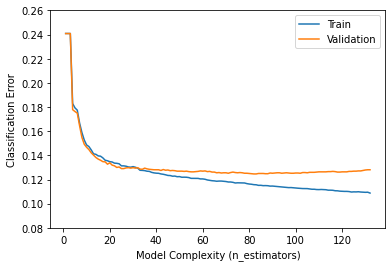

In [254]:
results = model.evals_result_
train_error = results['training']['binary_error']
val_error = results['valid_1']['binary_error']
%matplotlib inline 
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.08, 0.26)) # Zoom in
plt.legend();

### n_estimators 튜닝 결과

In [255]:
print('훈련 정확도: ', model.score(X_train_simple, y_train))
print('검증 정확도', model.score(X_val_simple, y_val))

print(classification_report(y_val, model.predict(X_val_simple)))

y_pred_proba = model.predict_proba(X_val_simple)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_val, model.predict(X_val_simple)))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

훈련 정확도:  0.8842145704269317
검증 정확도 0.8753361505954668
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.79      0.66      0.72      1254

    accuracy                           0.88      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.88      0.87      5206

AUC score:  0.9255686459201001
오차행렬 :  [[3726  226]
 [ 423  831]]


### --> 데이터 갯수나 시간적 상황 등 고려했을 때, 좀 더 효율적인 early stopping 튜닝으로 완료

# 7. 최적의 임계값 찾기

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

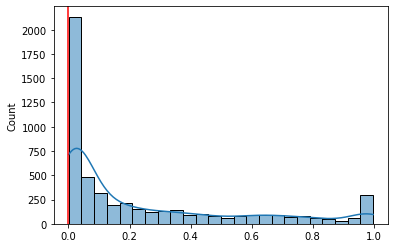

In [256]:
# 임계값 시각화

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(pd.Series(y_pred).value_counts())
    y_pred_auc =  np.where(y_pred=='True', 1, 0) 
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

In [257]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, 1] 

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.998101
1,0.000000,0.000797,0.998101
2,0.000000,0.045455,0.996176
3,0.000000,0.047049,0.996165
4,0.000000,0.140351,0.985473
...,...,...,...
1136,0.989119,1.000000,0.001852
1137,0.989626,1.000000,0.001850
1138,0.992156,1.000000,0.001681
1139,0.992662,1.000000,0.001674


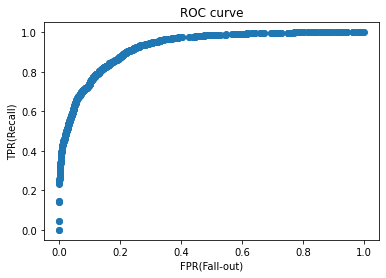

In [258]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [270]:
# threshold 최대값의 인덱스, np.argmax() 최대값 찾기.-->인덱스 뽑아내기.  재현율 - 위양성률 = 최적의 임계값
# 재현율이 가장 높으면서 위양성률이 가장 낮은 지점이 최적의 임계값.

optimal_idx = np.argmax(tpr - fpr)  # 최대값이 되는 인덱스
optimal_threshold = thresholds[optimal_idx]  # thresholds의 257번째 값.

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 742 , threshold: 0.18151961534262862


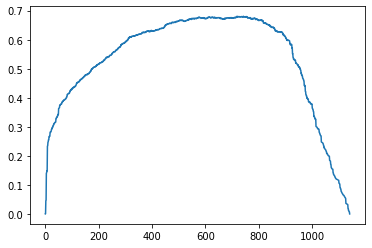

In [271]:
plt.plot(tpr-fpr);

In [273]:
# 최적의 임계값.

y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))
print(roc_auc_score(y_val, y_pred_proba))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3952
           1       0.56      0.90      0.69      1254

    accuracy                           0.81      5206
   macro avg       0.76      0.84      0.78      5206
weighted avg       0.87      0.81      0.82      5206

0.9255686459201001


In [264]:
# 임계값 0.5와 비교
y_pred_05 = y_pred_proba >= 0.5
print(classification_report(y_val, y_pred_05))
print(roc_auc_score(y_val, y_pred_proba))

# 오히려 별로가 되었는데...?
# 이런 경우는 뭐지?

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3952
           1       0.79      0.66      0.72      1254

    accuracy                           0.88      5206
   macro avg       0.84      0.80      0.82      5206
weighted avg       0.87      0.88      0.87      5206

0.9255686459201001


#7.최종모델 test데이터에 적용

In [274]:
X_test_encoded = encoder.transform(X_test)
X_test_simple = simpleimputer.transform(X_test_encoded)

In [275]:
print('검증 정확도', model.score(X_test_simple, y_test))

print(classification_report(y_test, model.predict(X_test_simple)))

# 거의 동일한 결과. 과적합 피할 수 있게 함.

y_pred_proba = model.predict_proba(X_test_simple)[:, -1]
print('AUC score: ', roc_auc_score(y_test, y_pred_proba))
print('오차행렬 : ' , confusion_matrix(y_test, model.predict(X_test_simple)))

검증 정확도 0.8716963736939152
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4940
           1       0.78      0.65      0.71      1568

    accuracy                           0.87      6508
   macro avg       0.84      0.79      0.81      6508
weighted avg       0.87      0.87      0.87      6508

AUC score:  0.9202357499173758
오차행렬 :  [[4660  280]
 [ 555 1013]]


#8.모델의 해석
- 특성의 값에 따라서 타겟값에 어떻게 영향을 미치느냐를 알아보자.

## 1) 부분의존도그림(PDP :Partial dependence plots)
- 개별 특성과 타겟과의 관계를 알아보자. 
- 아까전에 순열중요도에서 중요도 순서는 ['capital-gain', 'marital-status', 'occupation', 'age', 'education', 'capital-loss', 'hours-per-week', 'sex', 'workclass', 'race', 'education-num', 'native-country', 'fnlwgt', 'relationship'] 순이였음.
-  PDP분석은 특성과 타겟변수의 관계를 전체적으로만 파악할 수 있을뿐 개별 관측치에 대한 설명을 하기에는 부족합니다.

In [28]:
# 화질 조정
plt.rcParams['figure.dpi'] = 100

### 자본소득

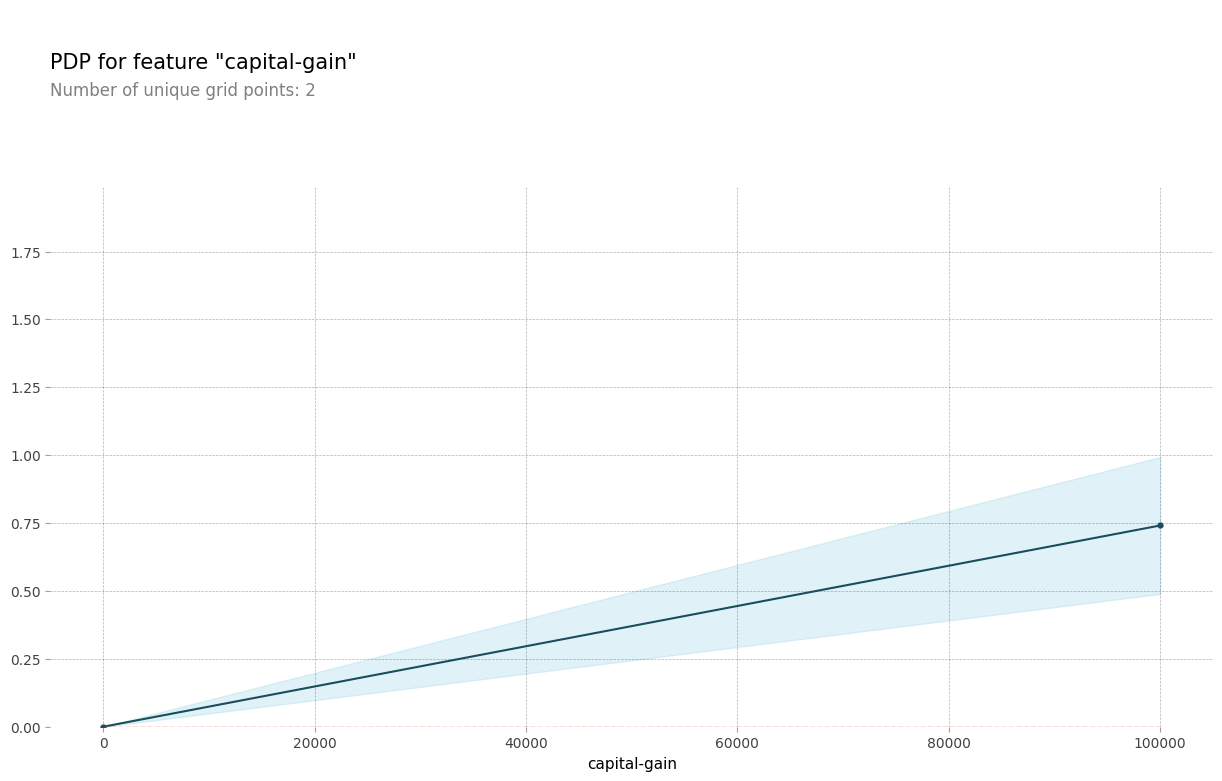

In [29]:
feature = 'capital-gain'

pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature_name=feature);  # 인코딩된 'capital-gain'값을 확인할 수 있습니다

# 'capital-gain'을 나타내는 변수값이 숫자로 코딩되었음.
# 자본소득이 많을수록 고소득일 확률이 높아진다. 

### 자본손실

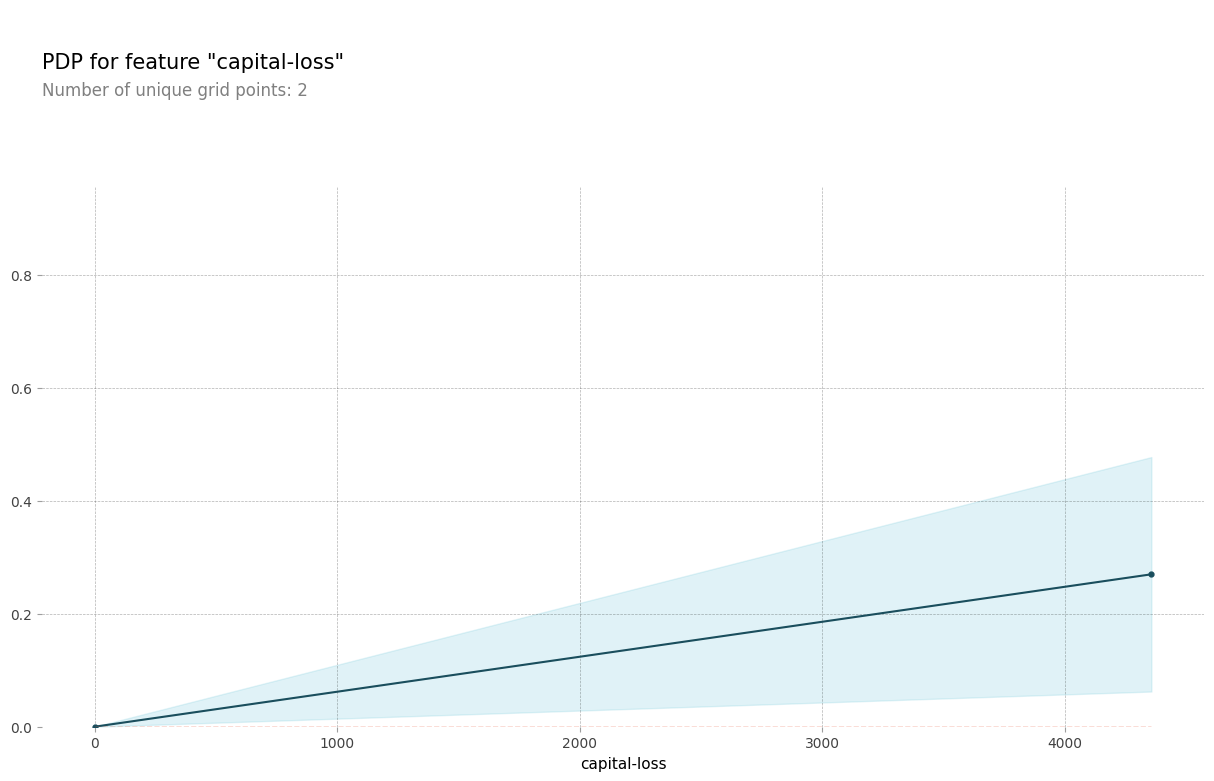

In [30]:
feature = 'capital-loss'

pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature_name=feature);

# 자본손실이 큰 사람일수록 고소득자일 확률도 높더라..

### 결혼 상태
-  Married-civ-spouse 기혼-시민-배우자, Divorced 이혼, Never-married 미혼, Separated 별거, Widowed 사별, Married-spouse-absent 기혼-배우자-부재, Married-AF-spouse기혼-공군-배우자.

In [31]:
feature = 'marital-status'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

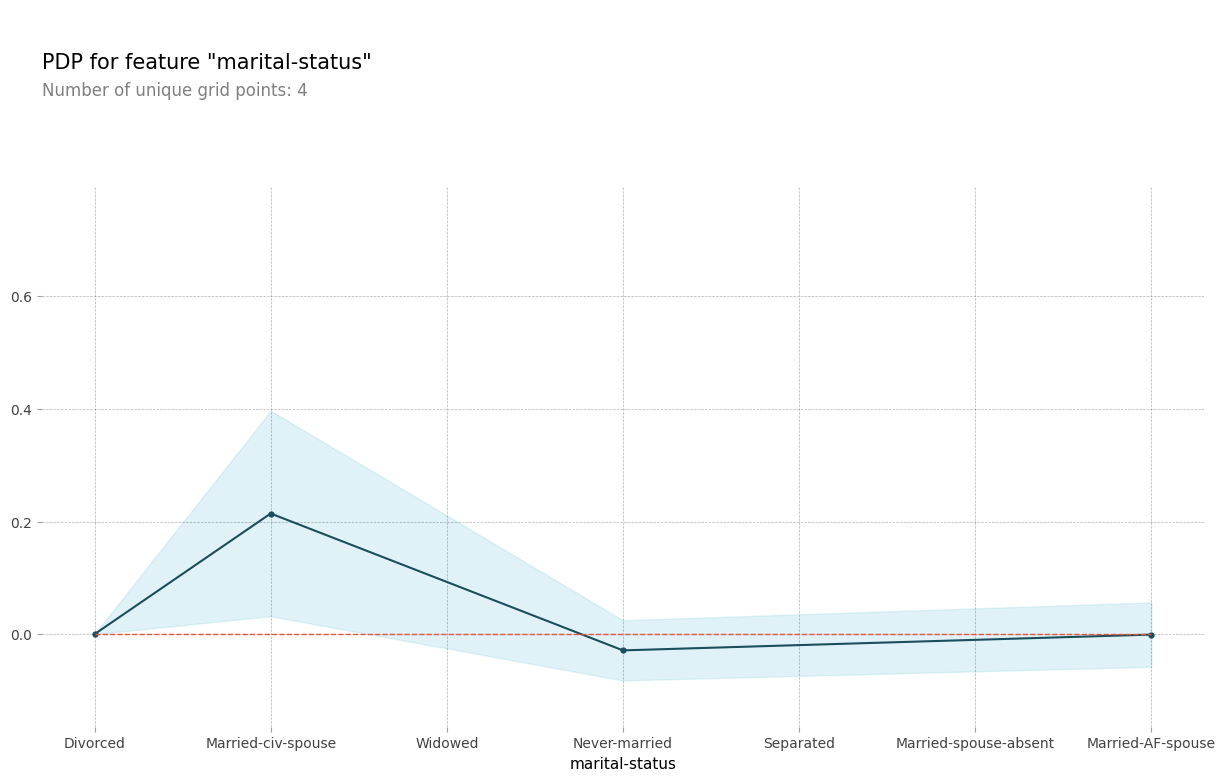

In [32]:
pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature)

plt.xticks(category_codes, category_names);

# Divorced(이혼), Never-married(미혼)보다는 별거든, 사별이든,배우자가 부재중이든 어쨌든 한번 결혼해본 사람이 소득높을 확률이 높다.

### 나이

In [33]:
feature = 'age_cut'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

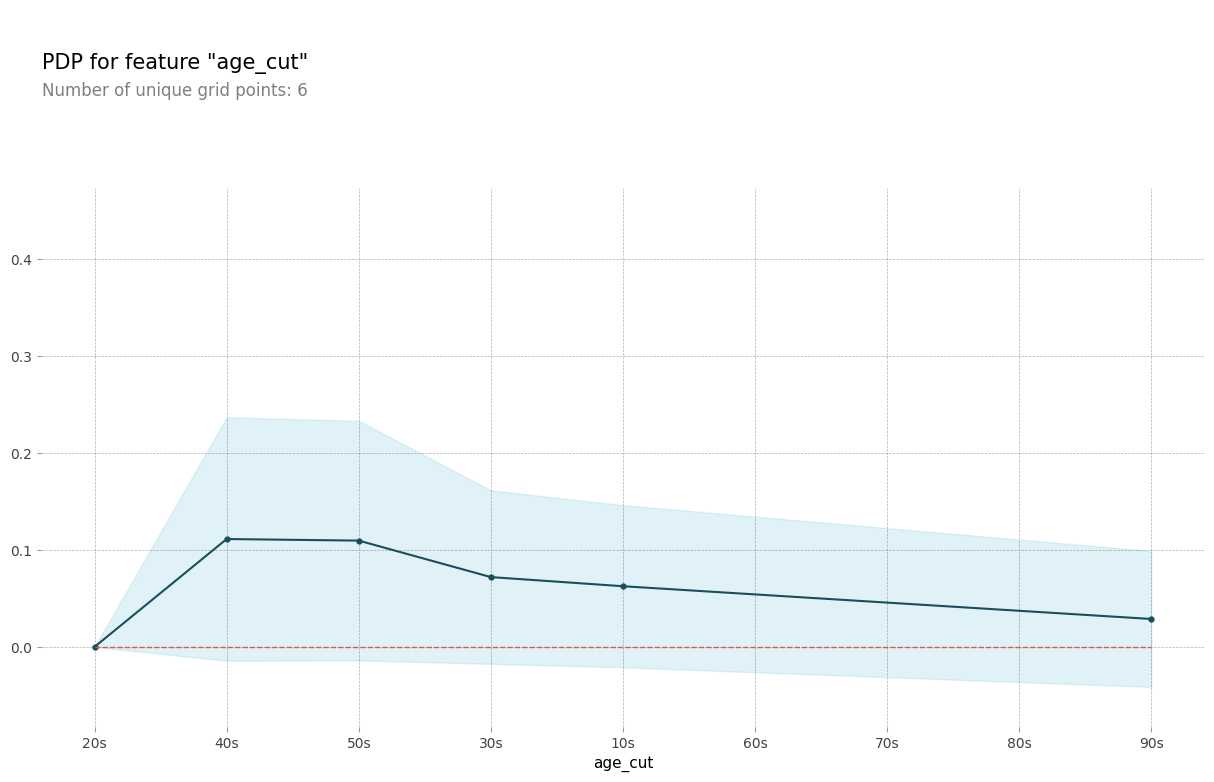

In [34]:
pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature)

plt.xticks(category_codes, category_names);

# 일단 살아있으면 고소득일 확률 긍정적 영향을 미치고는 있으나,
# 상대적으로 30대부터 40대, 50대에서 고소득일 확률이 높고, 나이가 들수록 그 확률이 줄어드는 양상을 보인다. 

### 학력
- (학력): Bachelors 학사, Some-college 일부대학, 11th 11학년, HS-grad 고졸, Prof-school 전문학교(로스쿨같은), Assoc-acdm(아카데미와 연관된), Assoc-voc(직업전문학교 연관된), 9th, 7th-8th, 12th, Masters 석사, 1st-4th, 10th, Doctorate 박사, 5th-6th, Preschool 유치원.

In [35]:
feature = 'education'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

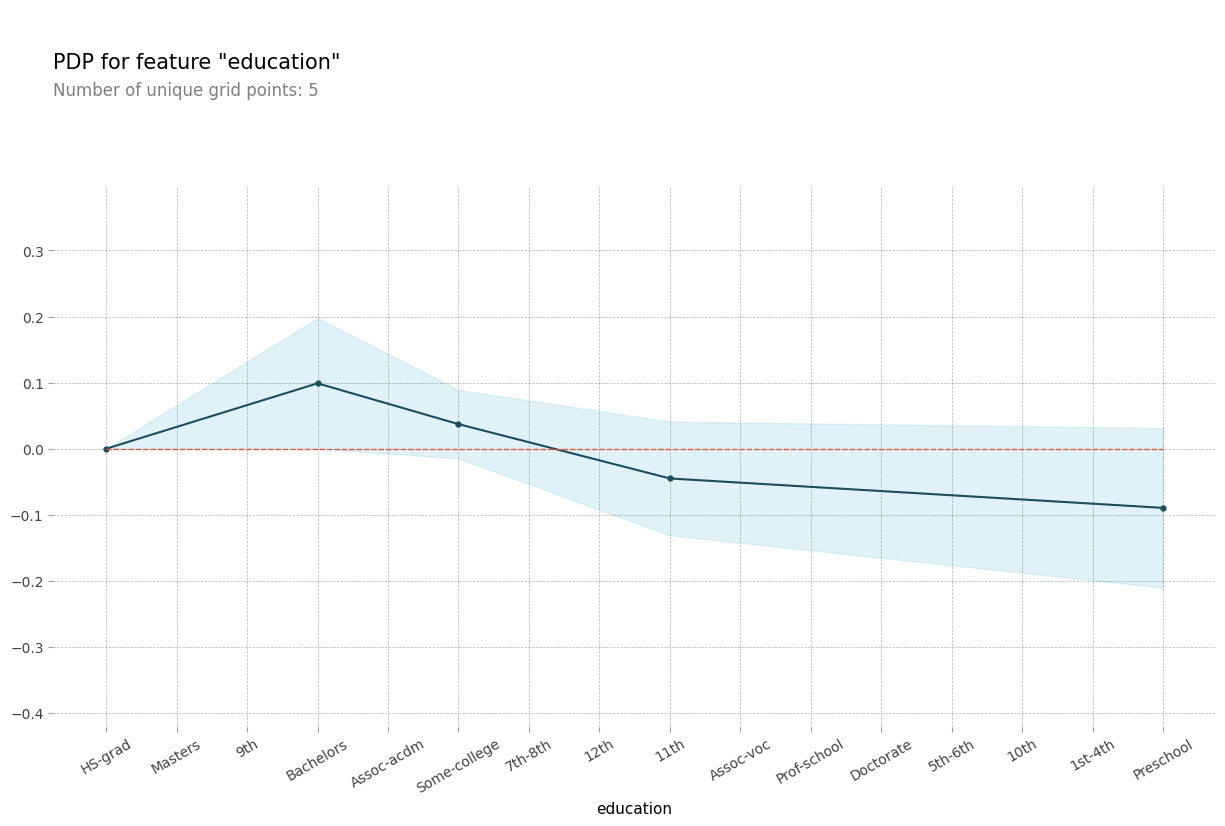

In [36]:
pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature)

plt.xticks(category_codes, category_names);
plt.xticks(rotation=30);

# 너무 저학력이면 곤란하다. 
# 학사, 박사의 학력자 중에 고소득자가 많다.  

### 직업군
- Tech-support 기술지원, Craft-repair 크래프트 수리( 배, 항공기, 우주선' 등 ), Other-service 기타서비스, Sales판매, Exec-managerial 간부관리, Prof-specialty전문 저문, Handlers-cleaners핸들러-청소부, Machine-op-inspct기계 작동 검사, Adm-clerical ADM - 사무, Farming-fishing 농업-낚시, Transport-moving 운송-이사, Priv-house-serv, Protective-serv, Armed-Forces군대.



In [37]:
# encoder 맵핑을 확인합니다, {male:1, female:2} 로 인코딩 되어 있습니다
encoder.mapping

[{'col': 'workclass', 'data_type': dtype('O'), 'mapping': Private             1
  Local-gov           2
  Self-emp-not-inc    3
  Federal-gov         4
  Self-emp-inc        5
  State-gov           6
  NaN                 7
  Without-pay         8
  Never-worked        9
  dtype: int64},
 {'col': 'education', 'data_type': dtype('O'), 'mapping': HS-grad          1
  Masters          2
  9th              3
  Bachelors        4
  Assoc-acdm       5
  Some-college     6
  7th-8th          7
  12th             8
  11th             9
  Assoc-voc       10
  Prof-school     11
  Doctorate       12
  5th-6th         13
  10th            14
  1st-4th         15
  Preschool       16
  NaN             -2
  dtype: int64},
 {'col': 'marital-status',
  'data_type': dtype('O'),
  'mapping': Divorced                 1
  Married-civ-spouse       2
  Widowed                  3
  Never-married            4
  Separated                5
  Married-spouse-absent    6
  Married-AF-spouse        7
  NaN        

In [38]:
feature = 'occupation'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

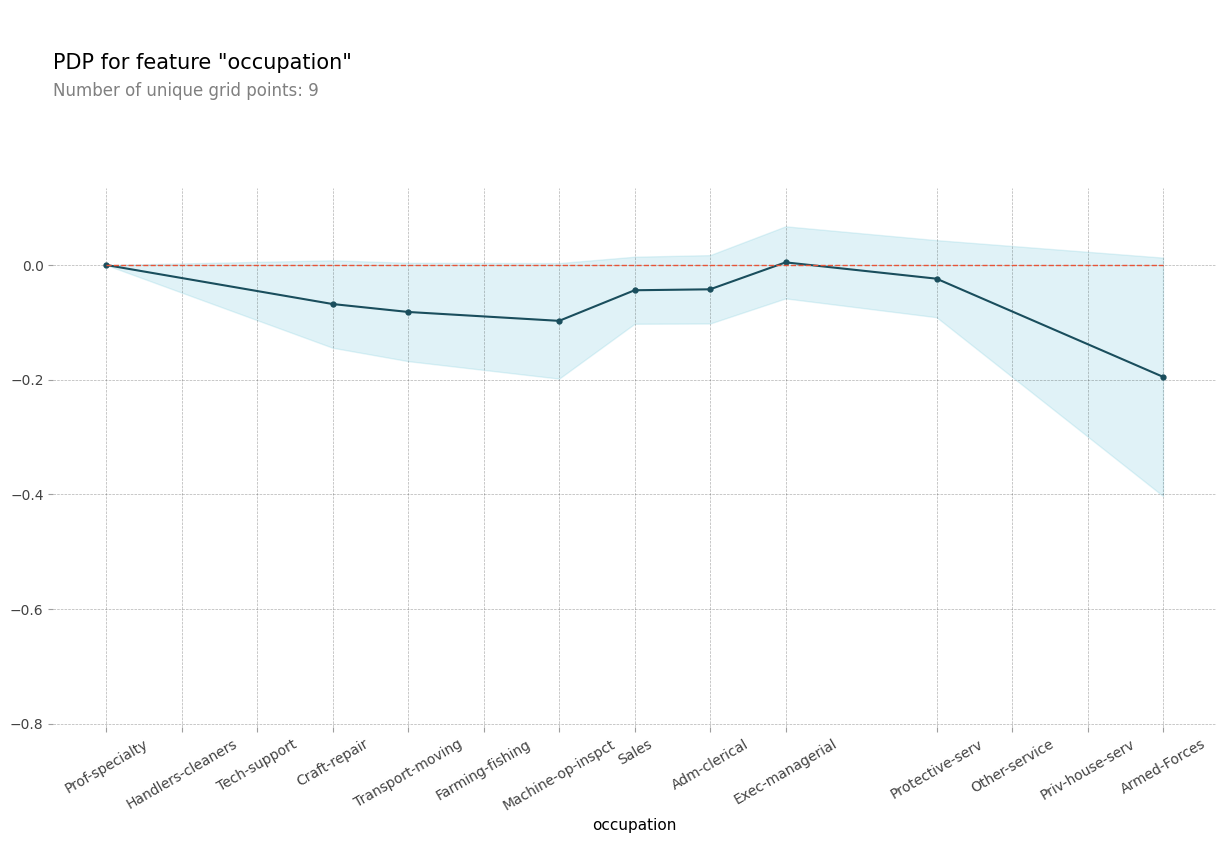

In [39]:
pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature)

plt.xticks(category_codes, category_names);
plt.xticks(rotation=30);

# 'Prof-specialty'(전문직),'Exec-managerial'(간부관리)

### 주당 일하는 시간

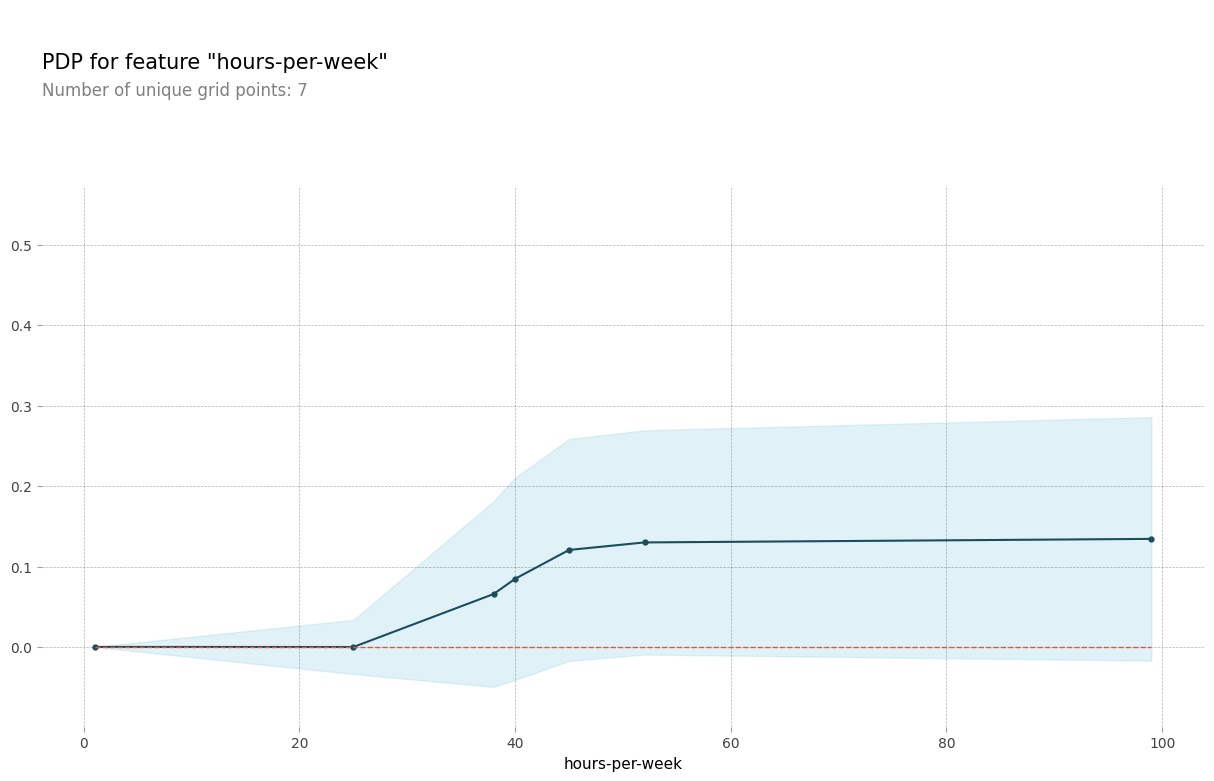

In [40]:
feature = 'hours-per-week'

pdp_dist = pdp.pdp_isolate(model=model,  #모델
                           dataset=X_test_encoded,  #검증데이터
                           model_features=X_test_encoded.columns,  # 총 피쳐
                           feature=feature,     # 확인하고자 하는 피쳐
                           grid_type='percentile' #백분위율로 나타냄
) 

pdp.pdp_plot(pdp_dist, feature_name=feature); 

# 당연하겠지만 일을 안하고있는 것보다야 일을 하는 사람이 소득이 높다. 
# 하지만 주당 100시간씩 일한다고 해서 꼭 고소득자가 될 확률이 더 커지는건 아니라는 점.

### PDP interact for "occupation" and "hours-per-week"

In [41]:
# 화질 조정
plt.rcParams['figure.dpi'] = 100

In [42]:
features = ['occupation', 'hours-per-week']  # 두 특성간의 의존성 확인

interaction = pdp_interact(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


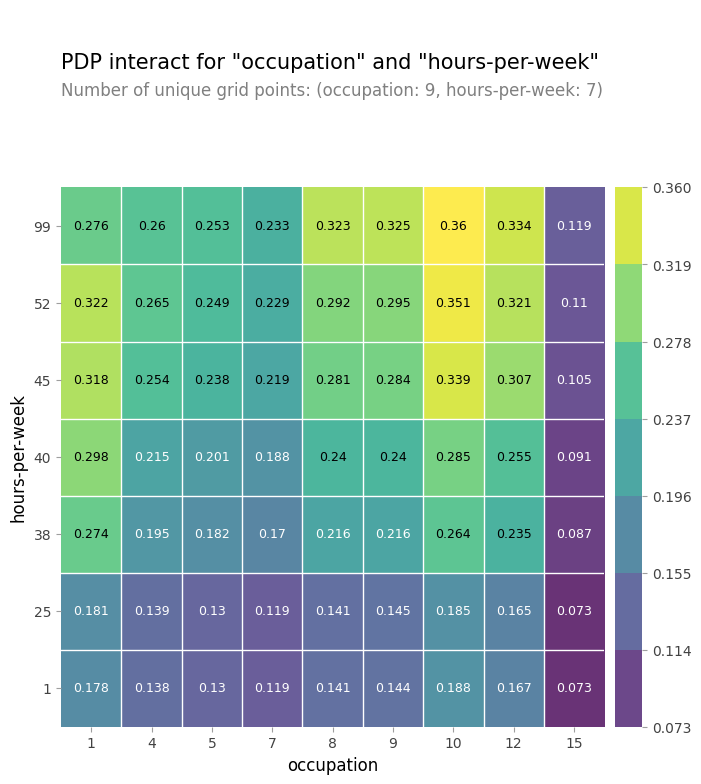

In [43]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

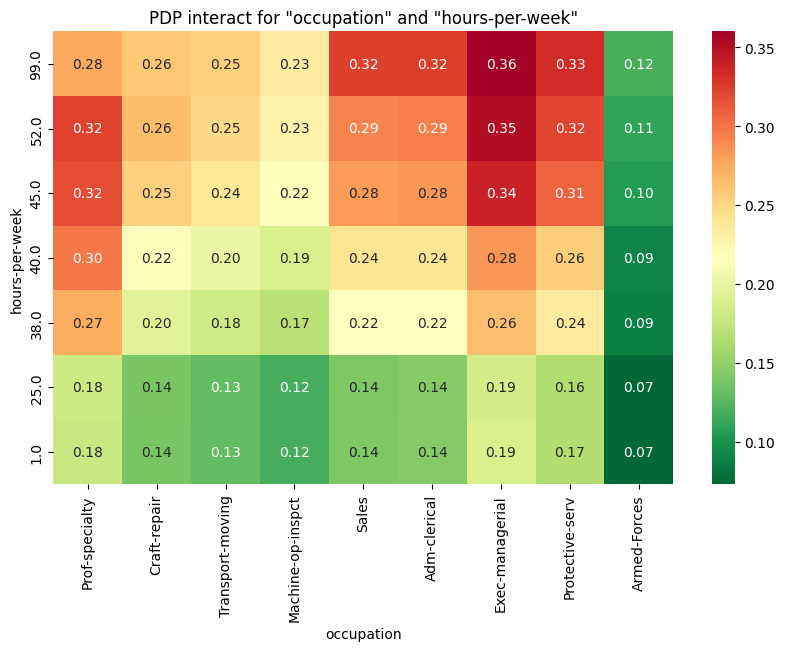

In [55]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1])[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,6))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='RdYlGn_r')

plt.title('PDP interact for "occupation" and "hours-per-week"');

# 직업이 'Prof-specialty'(전문직),'Exec-managerial'(간부관리)인 사람이 다른 직업군보다 고소득일 확률이 좀더 높은데, 그 중에서도
# 오래일하는 사람 말고 적당히 남들보다 더 일하는 사람.
# 오래 일한다고 해서 소득이 높은 것도 아님. 일 잘하는 사람은 적당히 일하고 가는 사람

# 세일즈(판매업)이나, 크래프트수리, 사무직도 다른 직업군보다 소득이 높을 확률이 높다는 걸 알수있다. 

# 히트맵 잘림 현상 : https://aigong.tistory.com/29

In [57]:
# heatmap by pandas
pdp.style.background_gradient(cmap='summer')

# 출처: https://rfriend.tistory.com/419 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

occupation,Prof-specialty,Craft-repair,Transport-moving,Machine-op-inspct,Sales,Adm-clerical,Exec-managerial,Protective-serv,Armed-Forces
hours-per-week,,,,,,,,,
99.0,0.275698,0.259957,0.253493,0.232714,0.323357,0.324944,0.360148,0.333525,0.119050
52.0,0.322126,0.264873,0.248627,0.228562,0.291739,0.294662,0.351485,0.321147,0.109909
45.0,0.317953,0.253919,0.237957,0.218534,0.281029,0.284440,0.338959,0.306832,0.104609
40.0,0.298066,0.215080,0.201239,0.187671,0.240261,0.240357,0.284754,0.255363,0.090552
38.0,0.274421,0.195097,0.182421,0.170188,0.215603,0.215689,0.263790,0.235290,0.087309
25.0,0.180572,0.139327,0.129931,0.118642,0.141207,0.144955,0.185081,0.164810,0.072742
1.0,0.178453,0.138451,0.129582,0.118544,0.141247,0.144227,0.188132,0.166624,0.073308


## 2) SHAP로 보는 개별관측치
- 단일 관측치로부터 특성들의 기여도(feature attribution)를 계산

In [98]:
X_test_encoded = encoder.transform(X_test)
X_test_simple = simpleimputer.transform(X_test_encoded)

print('검증 정확도', model.score(X_test_simple, y_test))
print(classification_report(y_test, model.predict(X_test_simple)))

class_index = 1
y_pred_proba = model.predict_proba(X_test_simple)[:, class_index]

print(f'Test AUC for class "{model.classes_[class_index]}": {roc_auc_score(y_test, y_pred_proba)}')
print()
print('오차행렬 : \n' , confusion_matrix(y_test, model.predict(X_test_simple)))

검증 정확도 0.8716963736939152
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4940
           1       0.78      0.65      0.71      1568

    accuracy                           0.87      6508
   macro avg       0.84      0.79      0.81      6508
weighted avg       0.87      0.87      0.87      6508

Test AUC for class "1": 0.9202357499173758

오차행렬 : 
 [[4660  280]
 [ 555 1013]]


In [59]:
y_pred = model.predict(X_test_simple)
y_pred.shape, y_pred_proba.shape, y_test.shape, X_test.shape

((6508,), (6508,), (6508,), (6508, 11))

In [60]:
# 예측값과 실제값 비교

df_pred = pd.DataFrame({
    'pred_proba': y_pred_proba, # 예측확률 
    'pred' : y_pred, # 예측값
    'status_group': y_test # 실제값 : 1 -->고소득자(연 5만달러 이상 소득)
})

df_p = pd.concat([X_test,df_pred], axis=1)
df_p.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut,pred_proba,pred,status_group
19292,Local-gov,145246,Masters,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,44,40s,0.744754,1,1
23725,Private,262841,HS-grad,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,50,30s,0.467659,0,1
1932,Private,162551,7th-8th,Married-civ-spouse,Machine-op-inspct,Other-relative,Female,0,0,48,20s,0.064089,0,0
29292,Private,308087,Some-college,Married-civ-spouse,Tech-support,Husband,Male,0,1977,18,50s,0.936391,1,1
17016,Private,367049,Masters,Never-married,Exec-managerial,Not-in-family,Female,4650,0,40,40s,0.130346,0,0


In [64]:
# 0,1을 원래 글자로 바꾸기
df_p['pred'] = np.where(df_p['pred']==1, '>50', '<=50') 
df_p['status_group'] = np.where(df_p['status_group']==1, '>50', '<=50') 

In [65]:
df_p.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut,pred_proba,pred,status_group
19292,Local-gov,145246,Masters,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,44,40s,0.744754,>50,>50
23725,Private,262841,HS-grad,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,50,30s,0.467659,<=50,>50
1932,Private,162551,7th-8th,Married-civ-spouse,Machine-op-inspct,Other-relative,Female,0,0,48,20s,0.064089,<=50,<=50
29292,Private,308087,Some-college,Married-civ-spouse,Tech-support,Husband,Male,0,1977,18,50s,0.936391,>50,>50
17016,Private,367049,Masters,Never-married,Exec-managerial,Not-in-family,Female,4650,0,40,40s,0.130346,<=50,<=50


In [99]:
over5 = df_p['status_group'] == '>50'  # 원래 y값에서, 5만달러 이상 고소득자
under5= ~over5    # test 셋에서, 5만달러 아닌사람.
right = (over5) == (df_p['pred_proba'] > 0.50)  # 데이터를 필터링 --> 5만달러 고소득자 중 예측을 맞게한 것만 True.
wrong = ~right    # 데이터를 필터링 --> # test 셋에서, 5만달러 고소득자 중 예측 틀린 것을 True 반환.

In [104]:
df_p[over5].shape # test 셋에서, 5만달러 고소득자

(1568, 14)

In [105]:
df_p[over5 & right].shape  # test 셋에서, 5만달러 고소득자 중 예측을 맞게한 것만 True.

(1013, 14)

### 5만달러 고소득자, 예측이 맞는 경우


In [110]:
# 샘플 10개만 추출
df_TP = df_p[over5 & right].sample(n=10, random_state=1).sort_values(by='pred_proba', ascending=False)
df_TP

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut,pred_proba,pred,status_group
3049,Self-emp-inc,122742,Assoc-acdm,Married-civ-spouse,Exec-managerial,Husband,Male,15024,0,55,30s,0.997466,>50,>50
16987,Private,175935,Bachelors,Divorced,Sales,Not-in-family,Male,14084,0,40,40s,0.996407,>50,>50
13733,Local-gov,493862,HS-grad,Married-civ-spouse,Exec-managerial,Husband,Male,7298,0,38,40s,0.989104,>50,>50
16261,Private,161662,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,42,50s,0.829615,>50,>50
23266,Self-emp-not-inc,427422,Doctorate,Married-civ-spouse,Sales,Husband,Male,0,2377,25,60s,0.781727,>50,>50
14864,Self-emp-inc,26698,Some-college,Married-civ-spouse,Sales,Husband,Male,0,1485,44,30s,0.709833,>50,>50
10951,Private,80771,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,30s,0.702031,>50,>50
21163,Private,369131,Assoc-acdm,Married-civ-spouse,Sales,Husband,Male,0,0,55,40s,0.674940,>50,>50
8550,Private,159247,Bachelors,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,40,30s,0.644914,>50,>50
6787,Private,155781,Bachelors,Married-civ-spouse,Sales,Husband,Male,0,0,40,30s,0.536936,>50,>50


In [118]:
df_TP.iloc[[0]]

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut,pred_proba,pred,status_group
3049,Self-emp-inc,122742,Assoc-acdm,Married-civ-spouse,Exec-managerial,Husband,Male,15024,0,55,30s,0.997466,>50,>50


In [164]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다

idx = df_TP.iloc[[0]].index[0]
row = X_test.loc[[idx]]
row

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut
3049,Self-emp-inc,122742,Assoc-acdm,Married-civ-spouse,Exec-managerial,Husband,Male,15024,0,55,30s


### shap 그래프로 예측 설명

In [165]:
explainer = shap.TreeExplainer(model)

row_encoded = encoder.transform(row)
row_processed= simpleimputer.transform(row_encoded)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

# 어떤 영향으로 99프로의 확률을 만든건지 설명하고 있음. --> 이 사람은 고소득자임.
# 이 사람은 부동산이나 자산증식에 관심이 많은지 자본소득이 높은 것이 결정적 요인이었음. 
# shap_values[0]은 네거티브 클래스에 대한 설명이고 shap_values[1]은 포지티브 클래스에 대한 설명 : https://github.com/slundberg/shap/issues/1252

### 예측을 shap그래프를 통해 설명하는 함수 만들기

In [175]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[1][0], zip(feature_names, feature_values))

In [176]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [177]:
print('고소득자 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

고소득자 예측에 대한 Positive 요인 Top 3 입니다:
1. capital-gain : 15024
2. marital-status : Married-civ-spouse
3. hours-per-week : 55


Negative 요인 Top 3 입니다:
1. capital-loss : 0
2. fnlwgt : 122742
3. education : Assoc-acdm


In [207]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.loc[[row_number]]
    row_encoded = encoder.transform(row)
    row_processed= simpleimputer.transform(row_encoded)

    # 예측하고 예측확률을 얻습니다 
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다.
    if pred == 1:
        pred_result = '50K 이상'
    elif pred == 0: 
        pred_result = '50k 이하'
    print(f'이 사람의 소득에 대한 예측결과는 "{pred_result}"(으)로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[1][0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value[1], 
        shap_values=shap_values[1], 
        features=row, 
        link='logit'
    )

In [203]:
i = df_TP.iloc[[5]].index[0]
explain(i)


# 결혼을 한 미국시민으로 배우자가 있고 간부관리라는 직종이면서, 학력은 석사다.
# 자본소득, 자본손실을 봤을때 예금, 주식, 펀드, 부동산 등에는 관심이 없어 보이고, 나이도 30대로 젊지만 고소득자가 거의 확실하다. 

이 사람의 소득에 대한 예측결과는 "50K 이상"(으)로, 확률은 71% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. marital-status : Married-civ-spouse
2. capital-loss : 1485
3. hours-per-week : 44


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. capital-gain : 0
2. fnlwgt : 26698
3. education : Some-college


### 고소득자 아닌사람, 예측이 성공한 경우

In [208]:
# 샘플 10개만 추출
df_TN = df_p[under5 & right].sample(n=10, random_state=2).sort_values(by='pred_proba')
df_TN

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut,pred_proba,pred,status_group
23486,Private,58972,Assoc-acdm,Divorced,Exec-managerial,Unmarried,Male,1506,0,40,30s,0.012482,<=50,<=50
18419,Private,114691,Bachelors,Never-married,Adm-clerical,Other-relative,Male,0,0,40,30s,0.013648,<=50,<=50
18819,Private,187720,Assoc-voc,Never-married,Craft-repair,Unmarried,Male,0,0,40,40s,0.032756,<=50,<=50
8676,Private,199903,Bachelors,Never-married,Prof-specialty,Not-in-family,Female,0,0,40,20s,0.032757,<=50,<=50
13734,Private,220754,HS-grad,Never-married,Adm-clerical,Not-in-family,Female,0,0,70,20s,0.033231,<=50,<=50
10190,Private,316820,7th-8th,Married-civ-spouse,Sales,Husband,Male,4064,0,40,40s,0.037474,<=50,<=50
22679,Self-emp-not-inc,88500,HS-grad,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,35,40s,0.151634,<=50,<=50
13004,Private,32271,Some-college,Married-civ-spouse,Craft-repair,Husband,Male,0,0,40,30s,0.247043,<=50,<=50
11346,NaN,260579,HS-grad,Married-civ-spouse,NaN,Husband,Male,0,0,40,50s,0.294207,<=50,<=50
12859,Private,248886,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Male,0,0,42,30s,0.386734,<=50,<=50


In [209]:
df_TN.iloc[[0]].index[0]

23486

In [210]:
i = df_TN.iloc[[0]].index[0]
X_test.loc[[i]]

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut
23486,Private,58972,Assoc-acdm,Divorced,Exec-managerial,Unmarried,Male,1506,0,40,30s


In [211]:
explain(i)

# 이혼한 상태에, 자본소득도 없고, 일도 남들처럼만 한다.
# 하지만 나이가 40대고, 전문직이라는 점에서 고소득자일 확률이 아주 없는 건 아니다. 정도로 해석할 수 있겠다. 

이 사람의 소득에 대한 예측결과는 "50k 이하"(으)로, 확률은 99% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. capital-gain : 1506
2. marital-status : Divorced
3. fnlwgt : 58972


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. occupation : Exec-managerial
2. sex : Male
3. workclass : Private


In [212]:
i = df_TN.iloc[[9]].index[0]
X_test.loc[[i]]

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut
12859,Private,248886,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Male,0,0,42,30s


In [214]:
explain(i)

이 사람의 소득에 대한 예측결과는 "50k 이하"(으)로, 확률은 61% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. education : HS-grad
2. capital-gain : 0
3. fnlwgt : 248886


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. marital-status : Married-civ-spouse
2. hours-per-week : 42
3. relationship : Husband


#9.잠재적 고객 확보를 위한 타겟팅

## Confusion matrix

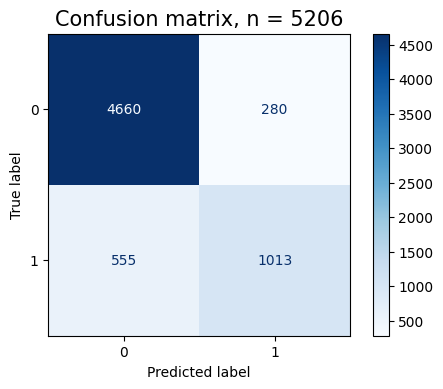

In [215]:
# Confusion matrix plt
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model, X_test_simple, y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);

plt.rcParams['figure.dpi'] = 100                            
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [216]:
cm = pcm.confusion_matrix
cm

array([[4660,  280],
       [ 555, 1013]])

In [217]:
tp = cm[1][1] #1256
tn = cm[0][0] #3840
fp = cm[0][1] # 794 
fn = cm[1][0] #214 
total = tp + tn + fp + fn
tp, tn, fp, fn

(1013, 4660, 280, 555)

In [218]:
# 매트릭스에서 분류 정확도(classification accuracy)계산하기.

correct_predictions = np.diag(cm).sum()
total_predictions = cm.sum()
correct_predictions/total_predictions

0.8716963736939152

In [219]:
# 정밀도
positives = tp + fp
tp/positives

0.7834493426140758

In [220]:
# 재현율
real_positives = tp + fn
tp / real_positives

0.6460459183673469

In [221]:
# 모든 사람에 대해, 5만달러 이상 소득일 확률
y_pred_proba = model.predict_proba(X_test_simple)[:, 1] 
y_pred_proba

array([0.74475374, 0.46765868, 0.06408864, ..., 0.00481817, 0.07626798,
       0.41978753])

In [223]:
X_test.shape

(6508, 11)

In [292]:
pred_proba = pd.DataFrame({
    'y_test': y_test,
    'pred_proba': y_pred_proba})  # y_pred_proba = 소득이 50만달러 이상일 확률
pred_proba

,y_test,pred_proba
19292,1,0.744754
23725,1,0.467659
1932,0,0.064089
29292,1,0.936391
17016,0,0.130346
...,...,...
12139,1,0.764532
7268,1,0.198773
31258,0,0.004818
23426,0,0.076268


In [304]:
X_test.loc[[1250]]

,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut
1250,Self-emp-inc,229465,Masters,Married-civ-spouse,Exec-managerial,Husband,Male,15024,0,50,50s


In [313]:
# 50k 이상 수입일 확률이 높은 사람 순서로 정렬.
# 만약 100명에게만 혜택을 줄 수 있다면?

top = pred_proba.sort_values(by='pred_proba', ascending=False)
top_k = top[top['pred_proba']>0.99]
top_k

,y_test,pred_proba
1250,1,0.997902
29723,1,0.997851
21414,1,0.997836
28489,1,0.997816
19088,1,0.997785
...,...,...
4555,1,0.990486
26816,1,0.990265
14916,1,0.990099
14779,1,0.990074


In [311]:
top_X_test = X_test.reset_index().rename(columns = {'index':'id'})

In [314]:
top_k = top_k.reset_index().rename(columns = {'index':'id'})

In [315]:
pd.merge(top_X_test, top_k, how='inner')

,id,workclass,fnlwgt,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,age_cut,y_test,pred_proba
0,27192,Private,167497,Some-college,Married-civ-spouse,Exec-managerial,Wife,Female,7688,0,50,30s,1,0.995568
1,24662,Private,120781,Masters,Married-civ-spouse,Exec-managerial,Husband,Male,15024,0,40,40s,1,0.997399
2,16352,Private,249322,Bachelors,Married-civ-spouse,Sales,Husband,Male,7688,0,50,50s,1,0.995151
3,32466,Private,121521,Prof-school,Married-civ-spouse,Prof-specialty,Husband,Male,15024,0,45,30s,1,0.997306
4,12655,Self-emp-inc,216711,HS-grad,Married-civ-spouse,Exec-managerial,Husband,Male,99999,0,50,30s,1,0.994730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,8872,Federal-gov,205288,HS-grad,Married-civ-spouse,Adm-clerical,Wife,Female,7688,0,35,50s,1,0.992340
160,19084,Self-emp-not-inc,140985,Bachelors,Married-civ-spouse,Adm-clerical,Wife,Female,99999,0,30,50s,1,0.996751
161,16619,Private,175360,Masters,Never-married,Adm-clerical,Not-in-family,Male,13550,0,50,30s,1,0.997101
162,1351,Self-emp-inc,199765,Bachelors,Married-civ-spouse,Craft-repair,Husband,Male,7688,0,50,30s,1,0.996234
